In [1]:
using Plots
using Statistics
using Turing
using ADTypes
using AdvancedHMC
using ReverseDiff
using BenchmarkTools
# using FFTA
# using ForwardDiff

In [6]:
methods(fft)

# 4 methods for generic function "fft" from AbstractFFTs:
 [1] fft(x::AbstractArray{<:Complex{<:Union{Integer, Rational}}}, region)
     @ ~/.julia/packages/AbstractFFTs/4iQz5/src/definitions.jl:216
 [2] fft(x::AbstractArray{<:Real}, region)
     @ ~/.julia/packages/AbstractFFTs/4iQz5/src/definitions.jl:214
 [3] fft(x::AbstractArray, region)
     @ ~/.julia/packages/AbstractFFTs/4iQz5/src/definitions.jl:67
 [4] fft(x::AbstractArray)
     @ ~/.julia/packages/AbstractFFTs/4iQz5/src/definitions.jl:66

In [14]:
x = collect(Float64,range(0, stop=10, length=2000))
fft_f(b) = sum(abs2, FFTA.fft( sin.(b.*x)))
∇fft_f(b) = ForwardDiff.derivative(fft_f, b)
∇fft_f(0.5)

ErrorException: type ForwardDiff.Dual{ForwardDiff.Tag{typeof(fft_f), Float64}, Float64, 1} not supported

In [2]:
x = collect(Float64,range(0, stop=10, length=2000))
y = 2.0 * x .+ 1.0 .+ randn(length(x))
μ_cache = Vector{Float64}(undef, length(x))
function linear_y!(m::T, b::T,
     x::AbstractVector{T}=x, 
     cache::AbstractVector{T} = μ_cache) where T <: AbstractFloat


    @inbounds for i in eachindex(x, cache)
        cache[i] = m * x[i] + b
    end
    return nothing
end
println(code_warntype(linear_y!))
@btime linear_y!(2.0, 1.0, $x, $μ_cache)

MethodInstance for linear_y!(::T, ::T, ::AbstractVector{T}, ::AbstractVector{T}) where T<:AbstractFloat
  from linear_y!(m::T, b::T, x::AbstractVector{T}, cache::AbstractVector{T}) where T<:AbstractFloat @ Main ~/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:4
Static Parameters
  T <: AbstractFloat
Arguments
  #self#::Core.Const(Main.linear_y!)
  m::AbstractFloat
  b::AbstractFloat
  x::AbstractVector{T} where T<:AbstractFloat
  cache::AbstractVector{T} where T<:AbstractFloat
Locals
  @_6::Any
  val::Nothing
  i::Any
Body::Nothing
1 ─       Core.NewvarNode(:(val))
│         nothing
│   %3  = Main.eachindex::Core.Const(eachindex)
│   %4  = (%3)(x, cache)::Any
│         (@_6 = Base.iterate(%4))
│   %6  = @_6::Any
│   %7  = (%6 === nothing)::Bool
│   %8  = Base.not_int(%7)::Bool
└──       goto #4 if not %8
2 ┄ %10 = @_6::Any
│         (i = Core.getfield(%10, 1))
│   %12 = Core.getfield(%10, 2)::Any
│   %13 = Main.:+::Core.Const(+)
│   %14 = Main.

In [79]:
function linear_y!(m::T, b::T, 
                  x::AbstractVector{T}, 
                  cache::AbstractVector{T}) where T <: AbstractFloat
    @inbounds for i in eachindex(x, cache)
        cache[i] = m * x[i] + b
    end
    return nothing
end

# Benchmark with all arguments interpolated
@btime linear_y!($2.0, $1.0, $x, $μ_cache)

  7.632 ns (0 allocations: 0 bytes)


In [80]:
using ForwardDiff
function linear_y!(m::ForwardDiff.Dual, b::ForwardDiff.Dual, 
                  x::AbstractVector{<:ForwardDiff.Dual}, 
                  cache::AbstractVector{T}) where T <: AbstractFloat
    @inbounds for i in eachindex(x, cache)
        cache[i] = m * x[i] + b
    end
    return nothing
end

linear_y! (generic function with 4 methods)

In [81]:
mutable struct VecCache
    store::Dict{DataType,Vector}
end
function VecCache(n::Integer; chunk::Integer = 8)
    # 1. ordinary reals
    store = Dict{DataType,Vector}()
    store[Float64] = Vector{Float64}(undef, n)

    # 2. pick a dual type and allocate its vector
    DualT = ForwardDiff.Dual{Nothing,Float64,chunk}  # Create concrete type
    store[DualT] = Vector{DualT}(undef, n)

    return VecCache(store)
end

getcache(vc::VecCache, ::Type{T}) where {T} = vc.store[T]

getcache (generic function with 1 method)

In [27]:
using ForwardDiff
using ReverseDiff
using ReverseDiff

struct cachestruct
    A::Vector{Float64}
    B::Vector{ForwardDiff.Dual}
end
@model function (cachedarr::cachestruct)(x,y)  
        σ ~ Exponential(1)
        m ~ Uniform(-10, 10)
        b ~ Uniform(-10, 10)

        # Arr1 = cachedarr.A
        # Arr2 = cachedarr.B
        # if typeof(σ) <:AbstractFloat
        #     buff = vc.A
        # else
        #     buff = vc.B        
        # end
        buff = σ isa AbstractFloat ? cachedarr.A : cachedarr.B   # no type test at runtime
        # buff = get_tmp(cached, σ)  # Use DiffCache to get a temporary buffer
        @views @inbounds @simd for i in eachindex(y)
            buff[i] = m * x[i] + b
            Turing.@addlogprob! -1/(2σ^2) * (y[i] - buff[i])^2 -
                        log(σ) - 0.5 * log(2π)
            # y[i] ~ Normal(buff[i], σ)
        end
        
end

# Create the cache properly
# cached = cachestruct(
#     zeros(length(x)),
#     zeros(ForwardDiff.Dual,length(x)),  # Use track function instead of direct construction
#     zeros(ReverseDiff.TrackedReal, length(x))))  # Use track function instead of direct construction
# )
# Create the cache properly
# cached = cachestruct(
#     zeros(length(x)),
#     get_tmp(DiffCache(zeros(length(x))), 0.0),  # Create DiffCache and get default buffer
#     ReverseDiff.track.(zeros(length(x)))
# )
# Create the cache properly
cached = cachestruct(
    zeros(length(x)),
    [ForwardDiff.Dual{Nothing,Float64,8}(0.0) for _ in 1:length(x)]  # Create vector of duals
)
cached(1.,3.)
# global typecheck = typeof(cached)

DynamicPPL.Model{cachestruct, (:x, :y), (), (), Tuple{Float64, Float64}, Tuple{}, DynamicPPL.DefaultContext}(cachestruct([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], ForwardDiff.Dual[Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)  …  Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0), Dual{Nothing}(0.0,0.0,0.0,

In [28]:
# workspace = VecCache(length(x))
function mymodel(x,y,nuts)
    cached = cachestruct(
    zeros(length(x)),
    [ForwardDiff.Dual{Nothing,Float64,8}(0.0) for _ in 1:length(x)],  # Create vector of duals
    ReverseDiff.track.(zeros(length(x)))
    )
    cached = DiffCache(zeros(length(x)))  # Create DiffCache with default buffer
    println(length(x), " ", length(y))
    
    cachestruct(cachedarr)
    # @turing.addlogprob 
    # for i in eachindex(y)
    #     y[i] ~ Normal(buff[i], σ)
    # end
    # @. buff = m * x + b
    # for i in eachindex(y)
    #     y[i] ~ Normal(buff[i], σ)
    # end
    # y ~ arraydist(Normal.(buff, σ))
    # μ = @. m * x + b
    # y ~ arraydist(Normal.(μ, σ))
    model = linear_turing(x,y)
    @benchmark sample(model, nuts, MCMCThreads(), 
                    n_samples, n_chains; 
                    progress=true, 
                    n_adapts=n_adapts, 
                    save_state=true, 
                    adtype = AutoReverseDiff(true))
    # return chain
    
end



δ_target = 0.65
ϵ0 = 0.1
D = 3
metric = DenseEuclideanMetric(D)
kernel = HMCKernel(Trajectory{MultinomialTS}(Leapfrog(ϵ0), ClassicNoUTurn(max_depth=7)))
# kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
mma = MassMatrixAdaptor(metric)
ssa = StepSizeAdaptor(δ_target, Leapfrog(ϵ0))
adaptor = StanHMCAdaptor(mma, ssa)
hmcsampler = AdvancedHMC.HMCSampler(kernel, metric, adaptor)  
nuts = externalsampler(hmcsampler)

n_adapts = 10_000
n_chains = 4
n_samples = 10^4
using PreallocationTools
# cached = DiffCache(x)
# cached = GeneralLazyBufferCache()
# model = linear_turing(x, y, cached)
model = cached(x,y)
@benchmark sample(model, nuts, MCMCThreads(), 
                    n_samples, n_chains; 
                    progress=true, 
                    n_adapts=n_adapts, 
                    save_state=true, 
                    # adtype = AutoReverseDiff(true),
                    adtype = AutoReverseDiff(true))
# @benchmark sample(model, nuts, MCMCThreads(), 
#                     n_samples, n_chains; 
#                     progress=true, 
#                     n_adapts=n_adapts, 
#                     save_state=true, 
#                     adtype = AutoForwardDiff())
# chain = mymodel(x, y, nuts)
# @benchmark mymodel($x, $y, $nuts)
# println(length(x), " ", length(y))
# mymodel(x, y, nuts)

Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:02:42
Sampling (4 threads)  50%|███████████████               |  ETA: 0:01:18
Sampling (4 threads)  75%|██████████████████████▌       |  ETA: 0:00:27
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:01:21
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:01:21
Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:03:23
Sampling (4 threads)  50%|███████████████               |  ETA: 0:01:20
Sampling (4 threads)  75%|██████████████████████▌       |  ETA: 0:00:27
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:01:22
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:01:22
Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:02:27
Samp

BenchmarkTools.Trial: 1 sample with 1 evaluation per sample.
 Single result which took 74.136 s (43.56% GC) to evaluate,
 with a memory estimate of 308.25 GiB, over 5302993538 allocations.

In [52]:
@model function fixed(x,y,cached::Vector{<:DiffCache})  
    σ ~ Exponential(1)
    m ~ Uniform(-10, 10)
    b ~ Uniform(-10, 10)

    # Arr1 = cachedarr.A
    # Arr2 = cachedarr.B
    # if typeof(σ) <:AbstractFloat
    #     buff = vc.A
    # else
    #     buff = vc.B        
    # end
    # buff = σ isa AbstractFloat ? cachedarr.A : cachedarr.B   # no type test at runtime
    buff = get_tmp(cached[1], σ)  # Use DiffCache to get a temporary buffer
    buff2 = get_tmp(cached[2], σ)  # Use DiffCache to get a temporary buffer
    # buff, buff2 = (get_tmp(cached[i],σ) for i in eachindex(cached))   # Use DiffCache to get a temporary buffer
    
    @. buff = m * x + b
    @. buff2 = buff + one(σ)  # Example of using a second cache for some operation
    @views @inbounds @simd for i in eachindex(y)
        # buff[i] = m * x[i] + b
        Turing.@addlogprob! (-1/(2σ^2) * (y[i] - buff[i])^2 - log(σ)) 
        # y[i] ~ Normal(buff[i], σ)
    end
        
end
cached = [DiffCache(zeros(length(x))) for _ in [1,2]]  # Create DiffCache with default buffer
model = fixed(x,y, cached)
# @benchmark sample(model, nuts, MCMCThreads(), 
#                     n_samples, n_chains; 
#                     progress=true, 
#                     n_adapts=n_adapts, 
#                     save_state=true, 
#                     # adtype = AutoReverseDiff(true),
#                     adtype = AutoReverseDiff(true))
@benchmark sample(model, nuts, MCMCThreads(), 
                    n_samples, n_chains; 
                    progress=true, 
                    n_adapts=n_adapts, 
                    save_state=true, 
                    adtype = AutoReverseDiff(true))

Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:03:25
Sampling (4 threads)  50%|███████████████               |  ETA: 0:01:29
Sampling (4 threads)  75%|██████████████████████▌       |  ETA: 0:00:31
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:01:33
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:01:33
Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:03:06
Sampling (4 threads)  50%|███████████████               |  ETA: 0:01:23
Sampling (4 threads)  75%|██████████████████████▌       |  ETA: 0:00:28
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:01:28
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:01:28
Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:04:15
Samp

CompositeException: TaskFailedException

    nested task error: TaskFailedException
    
        nested task error: InterruptException:
        Stacktrace:
          [1] macro expansion
            @ ~/.julia/packages/DynamicPPL/oX6N7/src/utils.jl:73 [inlined]
          [2] macro expansion
            @ ~/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X52sZmlsZQ==.jl:22 [inlined]
          [3] macro expansion
            @ ./simdloop.jl:77 [inlined]
          [4] macro expansion
            @ ~/.julia/packages/DynamicPPL/oX6N7/src/compiler.jl:555 [inlined]
          [5] fixed(__model__::DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, __varinfo__::DynamicPPL.ThreadSafeVarInfo{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3}}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3}}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3}}, Vector{Set{DynamicPPL.Selector}}}}, ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3}}, Vector{Base.RefValue{ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3}}}}, __context__::DynamicPPL.DefaultContext, x::Vector{Float64}, y::Vector{Float64}, cached::Vector{DiffCache{Vector{Float64}, Vector{Float64}}})
            @ Main ~/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X52sZmlsZQ==.jl:20
          [6] _evaluate!!
            @ ~/.julia/packages/DynamicPPL/oX6N7/src/model.jl:963 [inlined]
          [7] evaluate_threadsafe!!(model::DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, varinfo::DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3}}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3}}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3}}, Vector{Set{DynamicPPL.Selector}}}}, ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3}}, context::DynamicPPL.DefaultContext)
            @ DynamicPPL ~/.julia/packages/DynamicPPL/oX6N7/src/model.jl:952
          [8] evaluate!!
            @ ~/.julia/packages/DynamicPPL/oX6N7/src/model.jl:887 [inlined]
          [9] logdensity
            @ ~/.julia/packages/DynamicPPL/oX6N7/src/logdensityfunction.jl:94 [inlined]
         [10] Fix1
            @ ./operators.jl:1127 [inlined]
         [11] vector_mode_dual_eval!(f::Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, cfg::ForwardDiff.GradientConfig{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3}}}, x::Vector{Float64})
            @ ForwardDiff ~/.julia/packages/ForwardDiff/UBbGT/src/apiutils.jl:24
         [12] vector_mode_gradient!
            @ ~/.julia/packages/ForwardDiff/UBbGT/src/gradient.jl:98 [inlined]
         [13] gradient!(result::DiffResults.MutableDiffResult{1, Float64, Tuple{Vector{Float64}}}, f::Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, x::Vector{Float64}, cfg::ForwardDiff.GradientConfig{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3, Vector{ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, Float64, 3}}}, ::Val{true})
            @ ForwardDiff ~/.julia/packages/ForwardDiff/UBbGT/src/gradient.jl:39
         [14] gradient!
            @ ~/.julia/packages/ForwardDiff/UBbGT/src/gradient.jl:36 [inlined]
         [15] logdensity_and_gradient
            @ ~/.julia/packages/LogDensityProblemsAD/9uEsH/ext/LogDensityProblemsADForwardDiffExt.jl:116 [inlined]
         [16] Fix1
            @ ./operators.jl:1127 [inlined]
         [17] ∂H∂θ
            @ ~/.julia/packages/AdvancedHMC/dgxuI/src/hamiltonian.jl:38 [inlined]
         [18] step(lf::Leapfrog{Float64}, h::Hamiltonian{DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, GaussianKinetic, Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.Chunk{3}, Nothing, Nothing}}, Base.Fix1{typeof(LogDensityProblems.logdensity_and_gradient), LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.Chunk{3}, Nothing, Nothing}}}, z::AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}}, n_steps::Int64; fwd::Bool, full_trajectory::Val{false})
            @ AdvancedHMC ~/.julia/packages/AdvancedHMC/dgxuI/src/integrator.jl:229
         [19] step
            @ ~/.julia/packages/AdvancedHMC/dgxuI/src/integrator.jl:199 [inlined]
         [20] build_tree(rng::Random.TaskLocalRNG, nt::Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}, h::Hamiltonian{DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, GaussianKinetic, Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.Chunk{3}, Nothing, Nothing}}, Base.Fix1{typeof(LogDensityProblems.logdensity_and_gradient), LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.Chunk{3}, Nothing, Nothing}}}, z::AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}}, sampler::MultinomialTS{Float64}, v::Int64, j::Int64, H0::Float64)
            @ AdvancedHMC ~/.julia/packages/AdvancedHMC/dgxuI/src/trajectory.jl:623
         [21] build_tree(rng::Random.TaskLocalRNG, nt::Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}, h::Hamiltonian{DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, GaussianKinetic, Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.Chunk{3}, Nothing, Nothing}}, Base.Fix1{typeof(LogDensityProblems.logdensity_and_gradient), LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.Chunk{3}, Nothing, Nothing}}}, z::AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}}, sampler::MultinomialTS{Float64}, v::Int64, j::Int64, H0::Float64)
            @ AdvancedHMC ~/.julia/packages/AdvancedHMC/dgxuI/src/trajectory.jl:633
         [22] build_tree(rng::Random.TaskLocalRNG, nt::Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}, h::Hamiltonian{DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, GaussianKinetic, Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.Chunk{3}, Nothing, Nothing}}, Base.Fix1{typeof(LogDensityProblems.logdensity_and_gradient), LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.Chunk{3}, Nothing, Nothing}}}, z::AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}}, sampler::MultinomialTS{Float64}, v::Int64, j::Int64, H0::Float64) (repeats 3 times)
            @ AdvancedHMC ~/.julia/packages/AdvancedHMC/dgxuI/src/trajectory.jl:643
         [23] transition(rng::Random.TaskLocalRNG, τ::Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}, h::Hamiltonian{DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, GaussianKinetic, Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.Chunk{3}, Nothing, Nothing}}, Base.Fix1{typeof(LogDensityProblems.logdensity_and_gradient), LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.Chunk{3}, Nothing, Nothing}}}, z0::AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}})
            @ AdvancedHMC ~/.julia/packages/AdvancedHMC/dgxuI/src/trajectory.jl:692
         [24] transition(rng::Random.TaskLocalRNG, h::Hamiltonian{DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, GaussianKinetic, Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.Chunk{3}, Nothing, Nothing}}, Base.Fix1{typeof(LogDensityProblems.logdensity_and_gradient), LogDensityProblemsADForwardDiffExt.ForwardDiffLogDensity{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}, ForwardDiff.Chunk{3}, Nothing, Nothing}}}, κ::HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, z::AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}})
            @ AdvancedHMC ~/.julia/packages/AdvancedHMC/dgxuI/src/sampler.jl:59
         [25] step(rng::Random.TaskLocalRNG, model::AbstractMCMC.LogDensityModel{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, spl::HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, StanHMCAdaptor{WelfordCov{Float64}, NesterovDualAveraging{Float64}}}, state::AdvancedHMC.HMCState{AdvancedHMC.Transition{AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}}, @NamedTuple{n_steps::Int64, is_accept::Bool, acceptance_rate::Float64, log_density::Float64, hamiltonian_energy::Float64, hamiltonian_energy_error::Float64, max_hamiltonian_energy_error::Float64, tree_depth::Int64, numerical_error::Bool, step_size::Float64, nom_step_size::Float64}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, StanHMCAdaptor{WelfordCov{Float64}, NesterovDualAveraging{Float64}}}; kwargs::@Kwargs{init_params::Nothing, n_adapts::Int64, save_state::Bool, adtype::AutoReverseDiff{true}})
            @ AdvancedHMC ~/.julia/packages/AdvancedHMC/dgxuI/src/abstractmcmc.jl:157
         [26] step
            @ ~/.julia/packages/AdvancedHMC/dgxuI/src/abstractmcmc.jl:139 [inlined]
         [27] step(rng::Random.TaskLocalRNG, model::DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, sampler_wrapper::DynamicPPL.Sampler{Turing.Inference.ExternalSampler{HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, StanHMCAdaptor{WelfordCov{Float64}, NesterovDualAveraging{Float64}}}}}, state::Turing.Inference.TuringState{AdvancedHMC.HMCState{AdvancedHMC.Transition{AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}}, @NamedTuple{n_steps::Int64, is_accept::Bool, acceptance_rate::Float64, log_density::Float64, hamiltonian_energy::Float64, hamiltonian_energy_error::Float64, max_hamiltonian_energy_error::Float64, tree_depth::Int64, numerical_error::Bool, step_size::Float64, nom_step_size::Float64}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, StanHMCAdaptor{WelfordCov{Float64}, NesterovDualAveraging{Float64}}}, LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}; kwargs::@Kwargs{init_params::Nothing, n_adapts::Int64, save_state::Bool, adtype::AutoReverseDiff{true}})
            @ Turing.Inference ~/.julia/packages/Turing/UCuzt/src/mcmc/abstractmcmc.jl:65
         [28] macro expansion
            @ ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:168 [inlined]
         [29] macro expansion
            @ ~/.julia/packages/AbstractMCMC/fWWW0/src/logging.jl:16 [inlined]
         [30] mcmcsample(rng::Random.TaskLocalRNG, model::DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, sampler::DynamicPPL.Sampler{Turing.Inference.ExternalSampler{HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, StanHMCAdaptor{WelfordCov{Float64}, NesterovDualAveraging{Float64}}}}}, N::Int64; progress::Bool, progressname::String, callback::Nothing, discard_initial::Int64, thinning::Int64, chain_type::Type, kwargs::@Kwargs{init_params::Nothing, n_adapts::Int64, save_state::Bool, adtype::AutoReverseDiff{true}})
            @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:116
         [31] mcmcsample
            @ ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:95 [inlined]
         [32] #sample#3
            @ ~/.julia/packages/Turing/UCuzt/src/mcmc/Inference.jl:204 [inlined]
         [33] sample
            @ ~/.julia/packages/Turing/UCuzt/src/mcmc/Inference.jl:193 [inlined]
         [34] (::AbstractMCMC.var"#36#49"{DynamicPPL.Sampler{Turing.Inference.ExternalSampler{HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, StanHMCAdaptor{WelfordCov{Float64}, NesterovDualAveraging{Float64}}}}}, DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, Random.TaskLocalRNG, UnitRange{Int64}, Bool, @Kwargs{chain_type::UnionAll, n_adapts::Int64, save_state::Bool, adtype::AutoReverseDiff{true}}, Int64, Vector{Any}, Nothing, Vector{UInt64}})()
            @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:370
    Stacktrace:
     [1] sync_end(c::Channel{Any})
       @ Base ./task.jl:466
     [2] macro expansion
       @ ./task.jl:499 [inlined]
     [3] (::AbstractMCMC.var"#35#48"{Bool, @Kwargs{chain_type::UnionAll, n_adapts::Int64, save_state::Bool, adtype::AutoReverseDiff{true}}, Int64, Int64, Vector{Any}, Nothing, Vector{UInt64}, Vector{DynamicPPL.Sampler{Turing.Inference.ExternalSampler{HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, UpperTriangular{Float64, Matrix{Float64}}}, StanHMCAdaptor{WelfordCov{Float64}, NesterovDualAveraging{Float64}}}}}}, Vector{DynamicPPL.Model{typeof(fixed), (:x, :y, :cached), (), (), Tuple{Vector{Float64}, Vector{Float64}, Vector{DiffCache{Vector{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}}, Vector{Random.TaskLocalRNG}, Int64, Int64})()
       @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:349

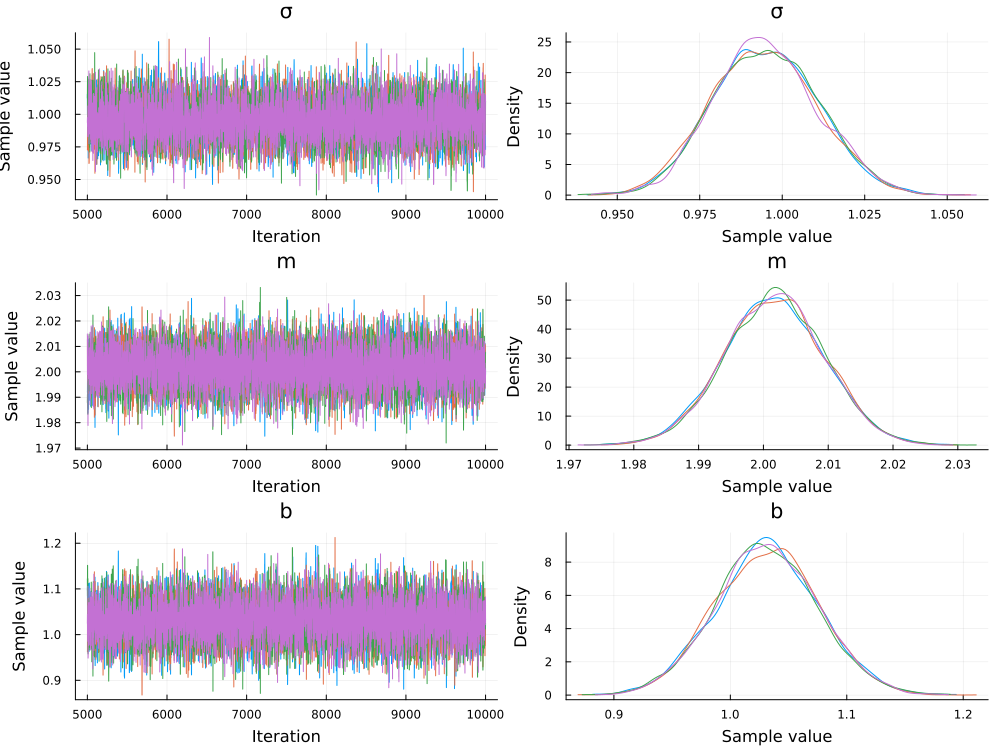

In [47]:
using StatsPlots
plot(chain[end÷2:end])

In [12]:
typecheck

ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{σ::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:m, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{Uniform{Float64}}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, DynamicPPL.Model{typeof(linear_turing), (:x, :y, :vc), (), (), Tuple{Vector{Float64}, Vector{Float64}, cachestruct}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.DefaultContext}}, Float64}, F

In [68]:
state  = chain.info.samplerstate        # one chain
dump(state.state.metric.M⁻¹)  # mass matrix
inv_mass_metric = state.state.metric.M⁻¹
ϵ0 = chain.info.samplerstate.state.κ.τ.integrator.ϵ

Array{Float64}((3, 3)) [0.0024839134874509454 -6.049455385201179e-6 5.324814606386588e-5; -6.049455385201183e-6 2.8736972578471715e-5 -0.00013694094905523306; 5.324814606386588e-5 -0.00013694094905523306 0.0008851223745693907]


1.2706218570872456

In [73]:
println(Matrix(inv_mass_metric))

[0.0024839134874509454 -6.049455385201179e-6 5.324814606386588e-5; -6.049455385201183e-6 2.8736972578471715e-5 -0.00013694094905523306; 5.324814606386588e-5 -0.00013694094905523306 0.0008851223745693907]


In [74]:
using Pathfinder
result_multi = multipathfinder(model, 1_000; nruns=n_chains)
inv_mm=result_multi.pathfinder_results[1].fit_distribution.Σ

3×3 Pathfinder.WoodburyPDMat{Float64, Diagonal{Float64, Vector{Float64}}, Matrix{Float64}, Matrix{Float64}, Pathfinder.WoodburyPDFactorization{Float64, Diagonal{Float64, Vector{Float64}}, LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}, Matrix{Float64}}, UpperTriangular{Float64, Matrix{Float64}}}}:
  0.00245934  -1.4112e-6     7.14949e-6
 -1.4112e-6    2.71131e-5   -0.000131006
  7.14949e-6  -0.000131006   0.000846906

In [19]:
methods(Exponential)

# 3 methods for type constructor:
 [1] Exponential()
     @ ~/.julia/packages/Distributions/YQSrn/src/univariate/continuous/exponential.jl:35
 [2] Exponential(θ::Integer; check_args)
     @ ~/.julia/packages/Distributions/YQSrn/src/univariate/continuous/exponential.jl:34
 [3] Exponential(θ::Real; check_args)
     @ ~/.julia/packages/Distributions/YQSrn/src/univariate/continuous/exponential.jl:29

In [29]:
# using Pkg
# Pkg.add("Mooncake")
using Mooncake

┌ Warning: Module ChainRules with build ID fafbfcfd-2ec5-110a-0000-b8caaa5ff22c is missing from the cache.
│ This may mean ChainRules [082447d4-558c-5d27-93f4-14fc19e9eca2] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Warning: Module Mooncake with build ID ffffffff-ffff-ffff-0000-48da5e2ada52 is missing from the cache.
│ This may mean Mooncake [da2b9cff-9c12-43a0-ae48-6db2b0edb7d6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Warning: Module Mooncake with build ID ffffffff-ffff-ffff-0000-48da5e2ada52 is missing from the cache.
│ This may mean Mooncake [da2b9cff-9c12-43a0-ae48-6db2b0edb7d6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541


In [35]:
using LinearAlgebra
@model function linear_turing2(x::T, y::T) where T <: AbstractVector 
    
    σ ~ Exponential(1.)
    m ~ Uniform(-10., 10.)
    b ~ Uniform(-10., 10.)
    # Turing.@addlogprob! sum(u -> -1/(2σ^2) * (u[2] - (m*u[1] + b))^2, zip(x,y))  # log likelihood
    @views @inbounds @simd for i in eachindex(y)
        # y[i] ~ Normal(m*x[i] +b, σ)
        # μ = m * x[i] + b
        # Turing.@addlogprob! -1/(2σ^2) * (y[i] - μ)^2 - log(σ)

        Turing.@addlogprob! -inv(2σ^2) * (y[i] - (m*x[i]+b))^2 - log(σ) 
    end

    # y ~ arraydist(Normal.(m.*x.+b, σ))
    # μ = @. m * x + b  # vectorized operation

    # y ~ arraydist(Normal.(μ, σ))

end



# δ_target = 0.65
# # ϵ0 = 0.1
# D = 3
# # metric = DenseEuclideanMetric(Matrix(inv(inv_mm)))  # Construct proper metric object
# # metric = Pathfinder.RankUpdateEuclideanMetric(inv_mm)
# metric = DenseEuclideanMetric(Matrix(inv(inv_mm)))
# kernel = HMCKernel(Trajectory{MultinomialTS}(Leapfrog(ϵ0), ClassicNoUTurn(max_depth=7)))
# # kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
# # mma = MassMatrixAdaptor(metric)
# # ssa = StepSizeAdaptor(δ_target, Leapfrog(ϵ0))
# # adaptor = StanHMCAdaptor(mma, ssa)
# # adaptor = StepSizeAdaptor(0.8, 1.0)  # adapt only the step size
# hmcsampler = AdvancedHMC.HMCSampler(kernel, metric, NoAdaptation())  
# hmcsampler = AdvancedHMC.HMCSampler(kernel, metric, adaptation)  

δ_target = 0.65
ϵ0 = 0.1
D = 3
metric = DenseEuclideanMetric(D)
kernel = HMCKernel(Trajectory{MultinomialTS}(Leapfrog(ϵ0), ClassicNoUTurn(max_depth=7)))
# kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
mma = MassMatrixAdaptor(metric)
ssa = StepSizeAdaptor(δ_target, Leapfrog(ϵ0))
adaptor = StanHMCAdaptor(mma, ssa)
hmcsampler = AdvancedHMC.HMCSampler(kernel, metric, adaptor)  
nuts = externalsampler(hmcsampler)
# nuts = externalsampler(hmcsampler)

n_adapts = 10_000
n_chains = 4
n_samples = 10^4
model2 = linear_turing2(x, y)
# chain2 = sample(model2, nuts, MCMCThreads(), 
#                     n_samples, n_chains; 
#                     progress=true, 
#                     n_adapts=n_adapts, 
#                     save_state=true, 
#                     adtype = AutoReverseDiff())
@benchmark sample(model2, nuts, MCMCThreads(), 
                    n_samples, n_chains; 
                    progress=true, 
                    n_adapts=n_adapts, 
                    save_state=true, 
                    adtype = AutoReverseDiff(true))

Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:00:11
Sampling (4 threads)  50%|███████████████               |  ETA: 0:00:04
Sampling (4 threads)  75%|██████████████████████▌       |  ETA: 0:00:01
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:03
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:03
Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:00:07
Sampling (4 threads)  50%|███████████████               |  ETA: 0:00:03
Sampling (4 threads)  75%|██████████████████████▌       |  ETA: 0:00:01
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:02
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:02
Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:00:08
Samp

BenchmarkTools.Trial: 2 samples with 1 evaluation per sample.
 Range (min … max):  2.751 s …    2.916 s  ┊ GC (min … max): 11.02% … 12.45%
 Time  (median):     2.834 s               ┊ GC (median):    11.75%
 Time  (mean ± σ):   2.834 s ± 116.653 ms  ┊ GC (mean ± σ):  11.75% ±  1.02%

  █                                                        █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.75 s         Histogram: frequency by time         2.92 s <

 Memory estimate: 2.71 GiB, allocs estimate: 46170021.

In [ ]:
2.697 s (45900228 allocations: 2.69 GiB)
5.849 s (47147434 allocations: 50.71 GiB)

In [39]:
using ADTypes
dump(ADTypes.MooncakeConfig)  # Will show all fields of the config struct

UndefVarError: UndefVarError: `MooncakeConfig` not defined in `ADTypes`
Suggestion: check for spelling errors or missing imports.

In [31]:
methods(AutoMooncake)

# 2 methods for type constructor:
 [1] AutoMooncake(; config)
     @ ~/.julia/packages/ADTypes/XeOm8/src/dense.jl:288
 [2] AutoMooncake(config::Tconfig) where Tconfig
     @ ~/.julia/packages/ADTypes/XeOm8/src/dense.jl:289

In [ ]:
dump(AutoMooncake

UnionAll
  var: TypeVar
    name: Symbol Tconfig
    lb: Union{}
    ub: Any
  body: AutoMooncake{Tconfig} <: AbstractADType
    config::Tconfig


In [34]:
propertynames(AutoMooncake)

(:var, :body)

In [21]:
@model function tmodel(x)
    p = Vector{Real}(undef, 1)
    p[1] ~ Normal()
    p = p .+ 1
    return x ~ Normal(p[1])
end
using Random

model = tmodel(1.0)

@code_warntype model.f(
    model,
    Turing.VarInfo(model),
    Turing.SamplingContext(
        Random.default_rng(), Turing.SampleFromPrior(), Turing.DefaultContext()
    ),
    model.args...,
)

MethodInstance for tmodel(::DynamicPPL.Model{typeof(tmodel), (:x,), (), (), Tuple{Float64}, Tuple{}, DynamicPPL.DefaultContext}, ::DynamicPPL.TypedVarInfo{@NamedTuple{p::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:p, Setfield.IndexLens{Tuple{Int64}}}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:p, Setfield.IndexLens{Tuple{Int64}}}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}, Float64}, ::DynamicPPL.SamplingContext{DynamicPPL.SampleFromPrior, DynamicPPL.DefaultContext, TaskLocalRNG}, ::Float64)
  from tmodel(__model__::DynamicPPL.Model, __varinfo__::DynamicPPL.AbstractVarInfo, __context__::AbstractPPL.AbstractContext, x) @ Main ~/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X40sZmlsZQ==.jl:1
Arguments
  #self#::Core.Const(Main.tmodel)
  __model__::DynamicPPL.Model{typeof(tmodel), (:x,), (), (), Tuple{Float64}, Tuple{}, DynamicPPL.DefaultContext}
  __varinfo__@_3::DynamicPPL.TypedVarInfo{@NamedTuple{p::DynamicPPL.Metadata{Dict{Abst

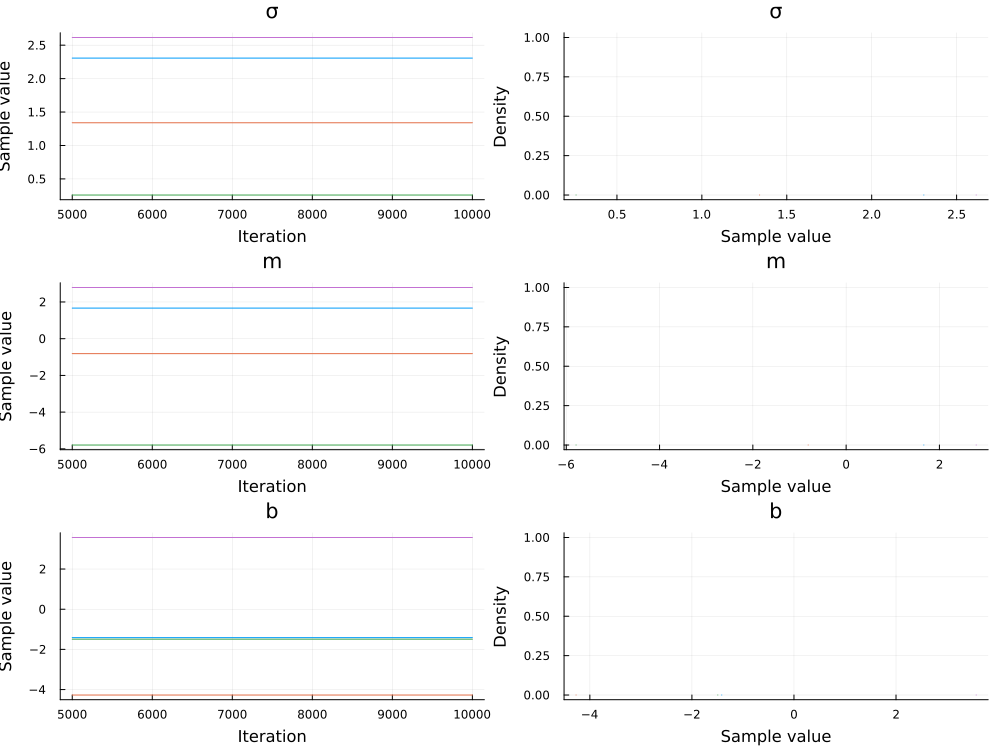

In [83]:
using StatsPlots
plot(chain2[end÷2:end])

In [34]:
using Serialization

# Save the chain to a file
open("chain-file.jls", "w") do io
    serialize(io, chain)
end

# Later, load the chain
chain2 = open("chain-file.jls", "r") do io
    deserialize(io)
end

Chains MCMC chain (10000×16×4 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 4
Samples per chain = 10000
Wall duration     = 1.96 seconds
Compute duration  = 7.21 seconds
parameters        = σ, m, b
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

           σ    1.0425    0.1381    0.0034   16185.5286   11955.8884    1.0001 ⋯
           m    2.0212    0.0982    0.0012   22711.6210   13357.5156    1.0002 ⋯
           b    0.8840    0.2209    0.0048   19061.1651   12145.0372    1.0001 ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%   

In [35]:
dump(chain.info.samplerstate.state)

AdvancedHMC.HMCState{AdvancedHMC.Transition{AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}}, @NamedTuple{n_steps::Int64, is_accept::Bool, acceptance_rate::Float64, log_density::Float64, hamiltonian_energy::Float64, hamiltonian_energy_error::Float64, max_hamiltonian_energy_error::Float64, tree_depth::Int64, numerical_error::Bool, step_size::Float64, nom_step_size::Float64}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}}, HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, StanHMCAdaptor{WelfordCov{Float64}, NesterovDualAveraging{Float64}}}
  i: Int64 10000
  transition: AdvancedHMC.Transition{AdvancedHMC.PhasePoint{Vector{Float64}, AdvancedHMC.DualValue{Float64, Vector{Float64}}}, @NamedTuple{n_steps::Int64, is_accept::Bool, acceptance_rate::Float64, log_density::Float64, hamiltonian_energy::Float64, hamilt

In [36]:
dump(chain.info.samplerstate.state.κ.τ.integrator.ϵ)

Float64 1.024355713240607


In [37]:
state  = chain.info.samplerstate        # one chain
dump(state.state.metric.M⁻¹)  # mass matrix
inv_mass_metric = state.state.metric.M⁻¹

Array{Float64}((3, 3)) [0.0025906542230082143 6.516303518971742e-6 -2.8509138554310282e-5; 6.516303518971745e-6 2.9206655548370668e-5 -0.00013912920844738057; -2.850913855431031e-5 -0.00013912920844738063 0.0008989090473318977]


3×3 Matrix{Float64}:
  0.00259065   6.5163e-6    -2.85091e-5
  6.5163e-6    2.92067e-5   -0.000139129
 -2.85091e-5  -0.000139129   0.000898909

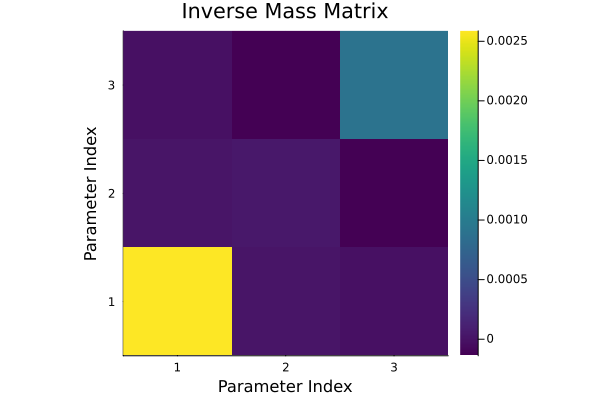

In [38]:
heatmap(log1p.(inv_mass_metric), 
aspect_ratio=:equal, color=:viridis,
title="Inverse Mass Matrix",
xlabel="Parameter Index",
ylabel="Parameter Index",
xticks=(1:D, 1:D),
yticks=(1:D, 1:D),
xlims=(0.5, D+0.5),
ylims=(0.5, D+0.5))

In [39]:
dump(state.state.adaptor.pc.cov)

Array{Float64}((3, 3)) [0.0025906542230082143 6.516303518971742e-6 -2.8509138554310282e-5; 6.516303518971745e-6 2.9206655548370668e-5 -0.00013912920844738057; -2.850913855431031e-5 -0.00013912920844738063 0.0008989090473318977]


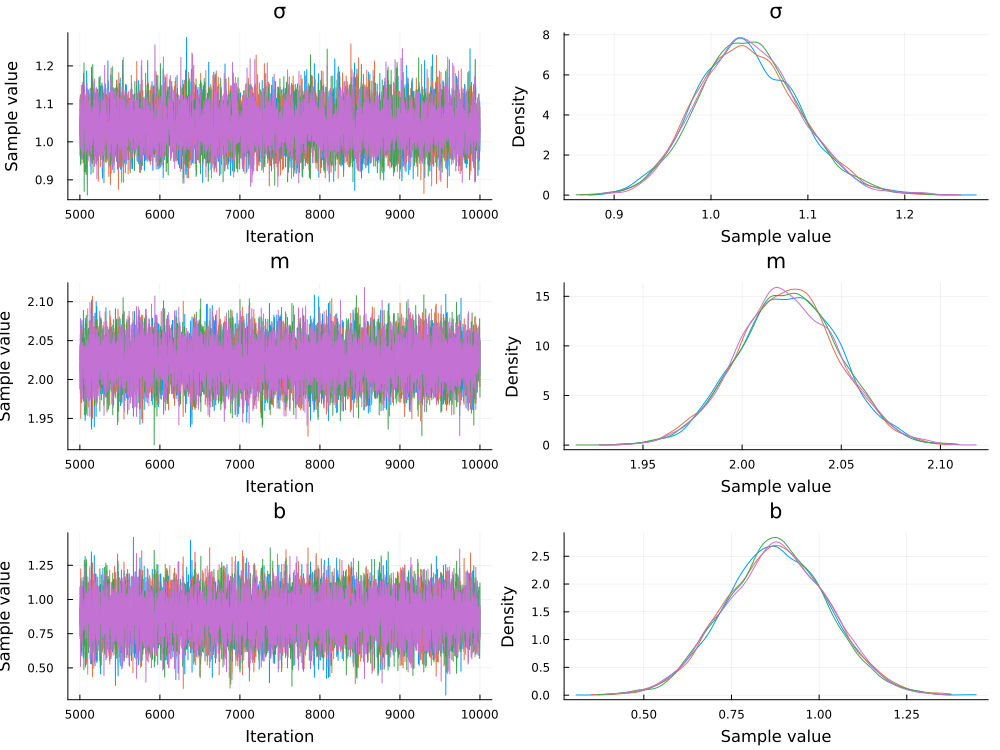

In [40]:
using StatsPlots
plot(chain[end÷2:end])

In [41]:
last_state = chain.info.samplerstate     # position + momenta + tuned metric
sampler    = chain.info.sampler          # NUTS object that already knows ε & M
println("Last state: ", sampler)

Last state: DynamicPPL.Sampler{Turing.Inference.ExternalSampler{HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}}, StanHMCAdaptor{WelfordCov{Float64}, NesterovDualAveraging{Float64}}}}}(Turing.Inference.ExternalSampler{HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}}, StanHMCAdaptor{WelfordCov{Float64}, NesterovDualAveraging{Float64}}}}(HMCSampler{HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, ClassicNoUTurn{Float64}}}, DenseEuclideanMetric{Float64, Vector{Float64}, Matrix{Float64}, LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}}, StanHM

In [42]:
methods(sample)

# 44 methods for generic function "sample" from StatsBase:
  [1] sample(rng::Random.AbstractRNG, wv::AbstractWeights)
     @ ~/.julia/packages/StatsBase/XgjIN/src/sampling.jl:552
  [2] sample(rng::Random.AbstractRNG, chn::Chains, n::Integer; replace, ordered)
     @ MCMCChains ~/.julia/packages/MCMCChains/RIFg4/src/sampling.jl:26
  [3] sample(rng::Random.AbstractRNG, chn::Chains, wv::AbstractWeights, n::Integer; replace, ordered)
     @ MCMCChains ~/.julia/packages/MCMCChains/RIFg4/src/sampling.jl:37
  [4] sample(rng::Random.AbstractRNG, a::AbstractArray{T}, dims::NTuple{N, Int64} where N; replace, ordered) where T
     @ ~/.julia/packages/StatsBase/XgjIN/src/sampling.jl:530
  [5] sample(rng::Random.AbstractRNG, a::AbstractArray{T}, n::Integer; replace, ordered) where T
     @ ~/.julia/packages/StatsBase/XgjIN/src/sampling.jl:509
  [6] sample(rng::Random.AbstractRNG, a::AbstractArray)
     @ ~/.julia/packages/StatsBase/XgjIN/src/sampling.jl:431
  [7] sample(rng::Random.AbstractRNG, a::AbstractArray, wv::AbstractWeights)
     @ ~/.julia/packages/StatsBase/XgjIN/src/sampling.jl:565
  [8] sample(rng::Random.AbstractRNG, a::AbstractArray{T}, wv::AbstractWeights, n::Integer; replace, ordered) where T
     @ ~/.julia/packages/StatsBase/XgjIN/src/sampling.jl:937
  [9] sample(rng::Random.AbstractRNG, a::AbstractArray{T}, wv::AbstractWeights, dims::NTuple{N, Int64} where N; replace, ordered) where T
     @ ~/.julia/packages/StatsBase/XgjIN/src/sampling.jl:944
 [10] sample(rng::Random.AbstractRNG, model::AbstractMCMC.AbstractModel, alg::Prior, ensemble::AbstractMCMC.AbstractMCMCEnsemble, N::Integer, n_chains::Integer; chain_type, progress, kwargs...)
     @ Turing.Inference ~/.julia/packages/Turing/UCuzt/src/mcmc/Inference.jl:269
 [11] sample(rng::Random.AbstractRNG, model::AbstractMCMC.AbstractModel, alg::Prior, N::Integer; chain_type, resume_from, progress, kwargs...)
     @ Turing.Inference ~/.julia/packages/Turing/UCuzt/src/mcmc/Inference.jl:211
 [12] sample(rng::Random.AbstractRNG, model::AbstractMCMC.AbstractModel, alg::Turing.Inference.InferenceAlgorithm, N::Integer; kwargs...)
     @ Turing.Inference ~/.julia/packages/Turing/UCuzt/src/mcmc/Inference.jl:183
 [13] sample(rng::Random.AbstractRNG, model::AbstractMCMC.AbstractModel, alg::Turing.Inference.InferenceAlgorithm, ensemble::AbstractMCMC.AbstractMCMCEnsemble, N::Integer, n_chains::Integer; kwargs...)
     @ Turing.Inference ~/.julia/packages/Turing/UCuzt/src/mcmc/Inference.jl:241
 [14] sample(rng::Random.AbstractRNG, model::AbstractMCMC.AbstractModel, sampler::AdvancedPS.SMC; kwargs...)
     @ AdvancedPS ~/.julia/packages/AdvancedPS/Vox9w/src/smc.jl:33
 [15] sample(rng::Random.AbstractRNG, model::AbstractMCMC.AbstractModel, sampler::DynamicPPL.Sampler{<:Turing.Inference.InferenceAlgorithm}, ensemble::AbstractMCMC.AbstractMCMCEnsemble, N::Integer, n_chains::Integer; chain_type, progress, kwargs...)
     @ Turing.Inference ~/.julia/packages/Turing/UCuzt/src/mcmc/Inference.jl:254
 [16] sample(rng::Random.AbstractRNG, model::AbstractMCMC.LogDensityModel, sampler::AdvancedHMC.AbstractHMCSampler, parallel::AbstractMCMC.AbstractMCMCEnsemble, N::Integer, nchains::Integer; n_adapts, progress, verbose, callback, kwargs...)
     @ AdvancedHMC ~/.julia/packages/AdvancedHMC/dgxuI/src/abstractmcmc.jl:68
 [17] sample(rng::Random.AbstractRNG, model::AbstractMCMC.AbstractModel, sampler::AbstractMCMC.AbstractSampler, parallel::AbstractMCMC.AbstractMCMCEnsemble, N::Integer, nchains::Integer; kwargs...)
     @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:81
 [18] sample(rng::Random.AbstractRNG, model::AbstractMCMC.AbstractModel, sampler::DynamicPPL.Sampler{<:Turing.Inference.AdaptiveHamiltonian}, N::Integer; chain_type, resume_from, progress, nadapts, discard_adapt, discard_initial, kwargs...)
     @ Turing.Inference ~/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:91
 [19] sample(rng::Random.AbstractRNG, model::AbstractMCMC.AbstractModel, sampler::DynamicPPL.Sampler{<:SMC}, N:

In [43]:
# --- 2.  continue the run (no adaptation) -----------------------------------
more_draws = 20_000

chain2 = sample(model,
                externalsampler(sampler),  # reuse the tuned NUTS object
                MCMCThreads(),
                more_draws,
                n_chains;
                save_state = true, 
                resume_from = chain,  # continue from the last state
                n_adapts   = 0)        # turn adaptation off


Sampling (4 threads)   0%|                              |  ETA: N/A
Sampling (4 threads)  25%|███████▌                      |  ETA: 0:00:12
Sampling (4 threads)  50%|███████████████               |  ETA: 0:00:04
Sampling (4 threads)  75%|██████████████████████▌       |  ETA: 0:00:01
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:03
Sampling (4 threads) 100%|██████████████████████████████| Time: 0:00:03


Chains MCMC chain (20000×16×4 Array{Float64, 3}):

Iterations        = 1:1:20000
Number of chains  = 4
Samples per chain = 20000
Wall duration     = 2.19 seconds
Compute duration  = 8.23 seconds
parameters        = σ, m, b
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           σ    6.2986   68.7103    4.5495   164.1635   163.1639    6.0674     ⋯
           m   -3.7133    4.0626    0.3196   161.8763        NaN    3.2129     ⋯
           b   -0.9701    6.2529    0.4937   161.5134   160.0000    3.5927     ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%     25.0%     50.0%  

In [44]:
plot(chain2)

ErrorException: boundary (a,b) must have a < b